## Preparing the Data

In [ ]:
!mkdir data
!mkdir data/raw
!mkdir data/processed
!mkdir data/processed/unsplash
!wget https://unsplash.com/data/lite/latest -O data/raw/unsplash.zip
!unzip data/raw/unsplash -d data/raw/unsplash
!rm data/raw/unsplash.zip

In [1]:
# download the images
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image

input_dir = Path("data") / "raw" / "unsplash"
output_dir = Path("data") / "processed" / "unsplash"
df = pd.read_csv(input_dir / "photos.tsv000", sep='\t', header=0)

def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
        background = Image.new("RGB", im.size, (255, 255, 255))
        background.paste(im, mask = im.split()[3])
        return background
    else:
        return im
    
def download_and_process(i):
    try:
        url = df['photo_image_url'][i]
        photo_id = df['photo_id'][i]
        im = Image.open(requests.get(url, stream=True, timeout=2).raw)
        im = remove_transparency(im)
        im.thumbnail((1000, 1000), Image.ANTIALIAS)
        im.save(output_dir / (photo_id + '.jpg'), optimize=True)
    except:
        failed.append(i)

failed = []
for i in tqdm(df.index):
    download_and_process(i)

In [14]:
!mkdir data/processed/unsplash/train
!mkdir data/processed/unsplash/test
!mkdir data/processed/unsplash/val
import os

all_images = list(Path(output_dir).glob("*.jpg"))
for i, img_p in enumerate(all_images):
    if i < 15000:
        os.rename(img_p, output_dir / "train" / img_p.name)
    elif i < 20000:
        os.rename(img_p, output_dir / "test" / img_p.name)
    else:
        os.rename(img_p, output_dir / "val" / img_p.name)

In [171]:
from torch.utils.data import Dataset
import pytorch_lightning as pl
import torch
import numpy as np
import skimage.color as color

class ColorizeDataset(Dataset):    
    def __init__(self, image_path, transform=None):
        self.image_names = list(Path(image_path).glob("*.jpg"))
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        im = Image.open(image_name)
        
        # discard alpha channel
        im = im.convert('RGB')
        if self.transform:
            im = self.transform(im)
        im = np.asarray(im) / 255
        lab = color.rgb2lab(im)
        lab = torch.tensor(lab, dtype=torch.float32)
        
        return lab[:,:,0] / 100, (lab[:,:,1:] + 127) / 255
    
    @staticmethod
    def create_lab(x, y):
        return np.concatenate([x[:, :, np.newaxis] * 100, y * 255 - 127], axis=2)
    
    @staticmethod
    def lab2rgb(lab):
        return color.lab2rgb(lab)

In [244]:
import torchvision.transforms as transforms

class ColorizeDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage = None):
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
            ]),
            'test': transforms.Compose([
                transforms.Resize(224)
            ])
        }
        # split dataset
        if stage == 'fit':
            self.train, self.val = ColorizeDataset(output_dir / 'train', data_transforms['train']), ColorizeDataset(output_dir / 'val', data_transforms['val'])
        if stage == 'test':
            self.test = ColorizeDataset(output_dir / 'test', data_transforms['test'])

    def train_dataloader(self):
        return self.train
    
    def val_dataloader(self):
        return self.val
    
    def test_dataloader(self):
        return self.test
    
data = ColorizeDataModule()

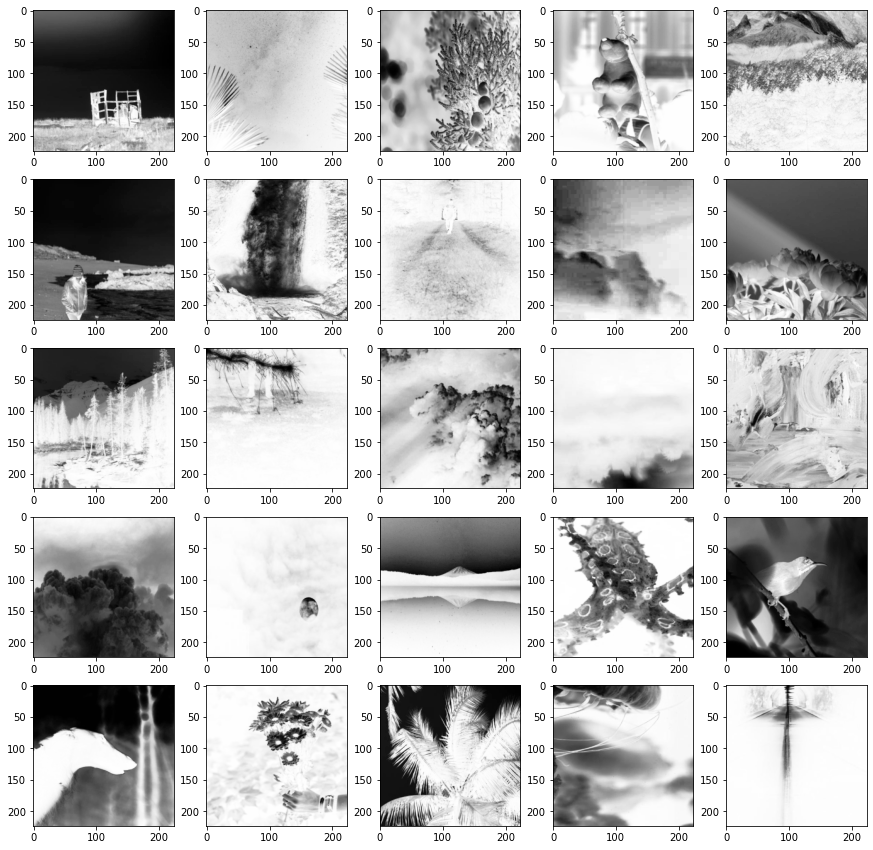

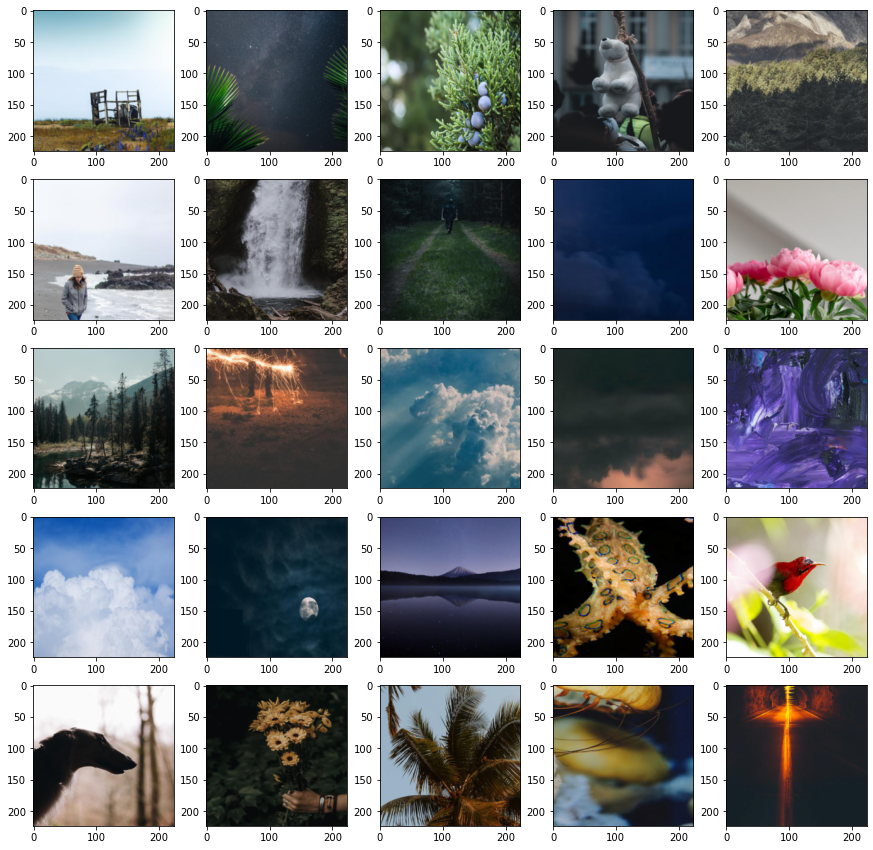

In [174]:
import matplotlib.pyplot as plt

fig1, axes1 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
fig2, axes2 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        x, y = image_datasets['train'][i * 5 + j]
        axes1[i][j].imshow(x, cmap='Greys')
        lab = ColorizeDataset.create_lab(x, y)
        axes2[i][j].imshow(ColorizeDataset.lab2rgb(lab))

In [237]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResnetAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        # replace first layer to take in single-channel inputs
        resnet.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        
        self.features = nn.Sequential(*list(resnet.children())[0:5]) # 256 x 56 x 56
        
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 128, 3), # 128 x 54 x 54
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 128 x 108 x 108
            nn.Conv2d(128, 64, 3), # 64 x 106 x 106
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((226, 226)), # 64 x 226 x 226
            nn.Conv2d(64, 2, 3), # 2 x 224 x 224
            nn.Sigmoid(),
        )

    def forward(self, x):
        assert(x.dim() in [3, 4])
        assert(x.shape[-1] == 224 and x.shape[-2] == 224)
        if x.dim() == 3:
            x = x.reshape(x.shape[0], 1, 224, 224)
        else: # x.dim() == 4
            assert(x.shape[1] == 1)
        
        features = self.features(x)
        return self.upsample(features)
    
    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [lr_scheduler]

In [238]:
model = ResnetAutoEncoder()
x = torch.zeros(16, 1, 224, 224)
y = model(x)
print(y.shape)
print(y.min())
print(y.max())

torch.Size([16, 2, 224, 224])
tensor(0.0193, grad_fn=<MinBackward1>)
tensor(0.9943, grad_fn=<MaxBackward1>)


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.trainer.Trainer(callbacks=[
    EarlyStopping(monitor='val_loss')
], max_epochs=10)

trainer.fit(model, datamodule=data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
